# PINN Demo

用 PINN 解这个常微分方程（ODE）：   
$u^{′′}(x)=−π2sin(πx),x∈[0,1]$, 边界条件：$u(0)=0,u(1)=0$   

真实解是：$u(x)=sin(πx)$   

我们就让 PINN 自己去“猜”出这个函数。

In [26]:
import deepxde as dde
import numpy as np
import torch

# 设置 backend
import os
os.environ["DDE_BACKEND"] = "pytorch"  # 或 "tensorflow.compat.v1"

定义常微分方程（ODE）：   
$u^{′′}(x)=−π2sin(πx),x∈[0,1]$, 边界条件：$u(0)=0,u(1)=0$   

In [19]:
def ode(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx + (np.pi**2) * torch.sin(np.pi * x)

定义集合区域   
定义边界条件

In [20]:
# 定义几何区域 [0, 1]
geom = dde.geometry.Interval(0, 1)

# 边界条件 u(0) = 0, u(1) = 0
bc_left = dde.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))
bc_right = dde.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 1))

构建数据

In [21]:
# 构建数据
data = dde.data.PDE(
    geom,
    ode,
    [bc_left, bc_right],
    num_domain=100,
    num_boundary=2,
    solution=lambda x: np.sin(np.pi * x),  # 用于测试准确度
)

In [22]:
# 网络结构
net = dde.maps.FNN([1] + [20] * 3 + [1], "tanh", "Glorot uniform") # 1个输入，3个隐藏层 (20个神经元)，1个输出

# 构建模型
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

Compiling model...
'compile' took 0.000264 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.97e+01, 0.00e+00, 1.06e+00]    [3.97e+01, 0.00e+00, 1.06e+00]    []  
1000      [2.60e-03, 1.57e-05, 1.82e-05]    [2.60e-03, 1.57e-05, 1.82e-05]    []  
2000      [8.41e-04, 9.85e-07, 1.42e-06]    [8.41e-04, 9.85e-07, 1.42e-06]    []  
3000      [4.74e-04, 2.12e-07, 1.35e-07]    [4.74e-04, 2.12e-07, 1.35e-07]    []  
4000      [2.38e-04, 7.36e-08, 1.49e-08]    [2.38e-04, 7.36e-08, 1.49e-08]    []  
5000      [8.95e-05, 2.17e-08, 1.28e-08]    [8.95e-05, 2.17e-08, 1.28e-08]    []  

Best model at step 5000:
  train loss: 8.96e-05
  test loss: 8.96e-05
  test metric: []

'train' took 3.933829 s



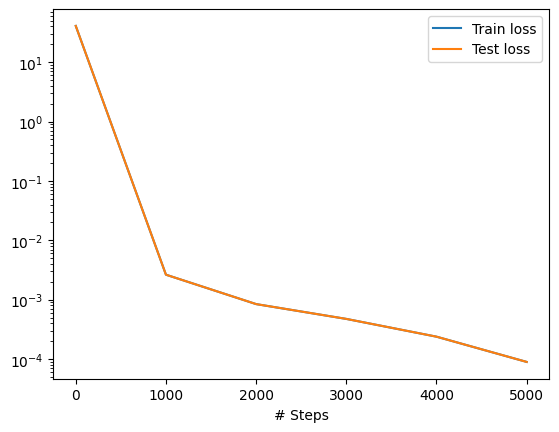

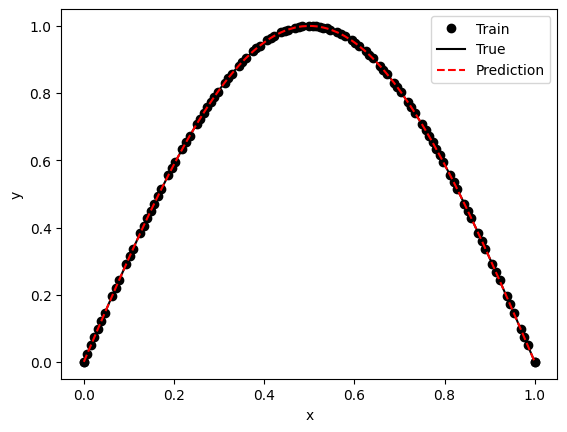

In [30]:
# 可视化预测和真实解对比
dde.saveplot(losshistory, train_state, issave=False, isplot=True)